In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media

from lib.multiSegmentActuator import *
from lib.Actuator import *
from lib.optimization import *

In [2]:
target = resampleUniform(CurveGenerator(nCtrl= 3, order = 2, nPoints=500), 500)
target /= np.linalg.norm(target[1:] - target[:-1], axis=-1).sum()

In [3]:
config = {'file': 'softActuator.xml',
          'mass': 0.1,
          'length': 0.3,
          'radius': 0.025,
          'numDisks': 16,
          'numSegments': 3,
          'fillRatio': 0.5,
          'innerStiffness': 0,
          'innerDamping': 1.0e5,
          'outerStiffness': 1.0e6,
          'outerDamping': 0.0,
          'gear': 1.0e5,
          'timeStep': 0.01,
          'camPosition': [0.15, 0.0, 2],
          'camOrientation': [0.0, 0.0, 0.0]}

""

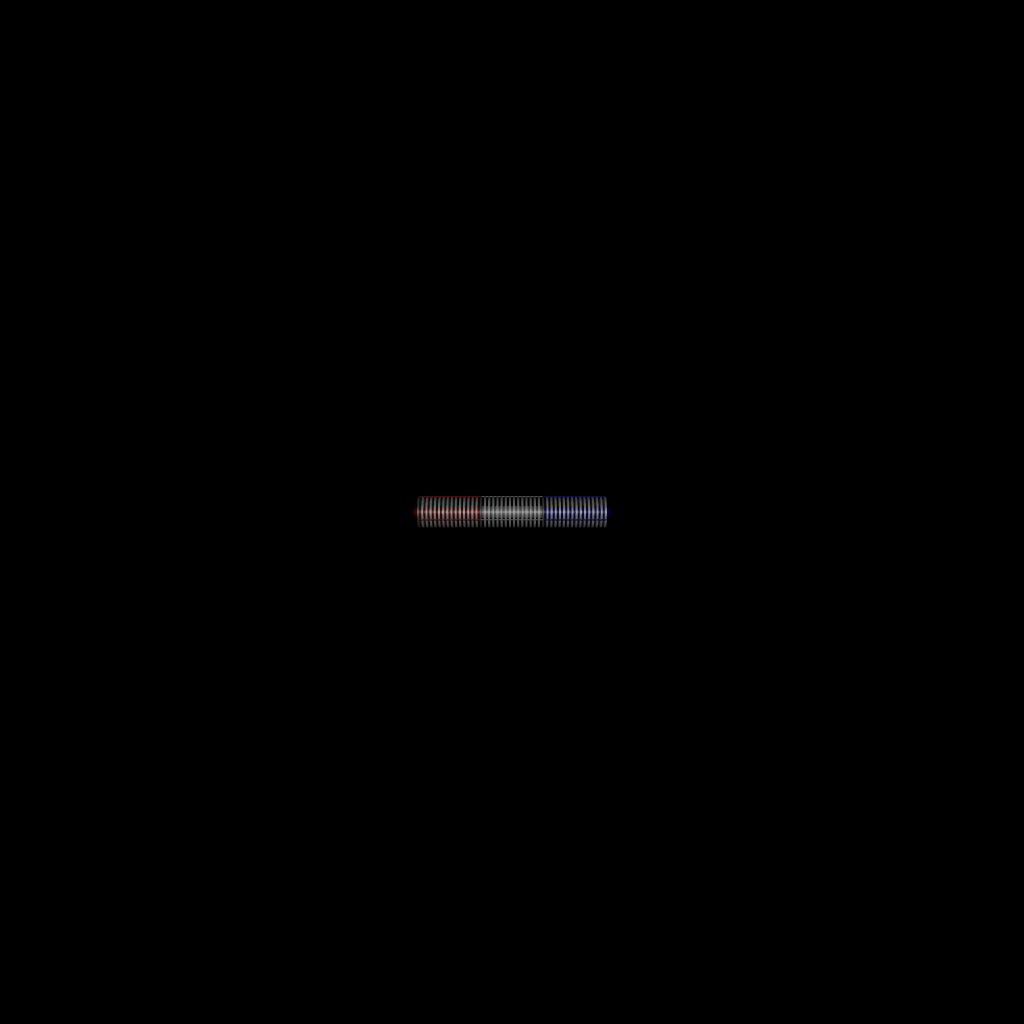

In [4]:
generateXML(config)
actuator3 = softActuator(config)
height = width = 1024
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    renderer.update_scene(actuator3.data, camera='mainCamera')
    imRef = renderer.render()
media.show_image(imRef)

In [5]:
optim = arcSplineOptimizer(actuator3, 1e-1, 0.995)
params, desired, loss = optim.optimize(target, 20000, 1000)

Iteration 1000: Loss = 0.001046144171
Iteration 2000: Loss = 0.001038640388
Iteration 3000: Loss = 0.001030697138
Iteration 4000: Loss = 0.001018562936
Iteration 5000: Loss = 0.001001443714
Iteration 6000: Loss = 0.000979326665
Iteration 7000: Loss = 0.000953208946
Iteration 8000: Loss = 0.000924033462
Iteration 9000: Loss = 0.000891519536
Iteration 10000: Loss = 0.000856375089
Iteration 11000: Loss = 0.000822303176
Iteration 12000: Loss = 0.000792315230
Iteration 13000: Loss = 0.000766998099
Iteration 14000: Loss = 0.000745866739
Iteration 15000: Loss = 0.000728210027
Iteration 16000: Loss = 0.000713424699
Iteration 17000: Loss = 0.000701023731
Iteration 18000: Loss = 0.000690583955
Iteration 19000: Loss = 0.000681787147
Iteration 20000: Loss = 0.000674370502


In [6]:
duration = 10 # (seconds)
framerate = 30  # (fps)

act = 1

# Simulate and display video.
frames = []
ii = 0
T = 5
actuator3.reset()
actuator3.setStiffness(params, act)
ctrl = np.zeros(3)
with mujoco.Renderer(actuator3.model, height, width) as renderer:
    while np.round(actuator3.data.time, 1-int(np.log10(0.01))) <= duration:
        ctrl = min((ii+1) / T, 1) * act
        actuator3.step(ctrl)
        if len(frames) < actuator3.data.time * framerate:
            renderer.update_scene(actuator3.data, camera='mainCamera')
            frame = renderer.render()
            frames.append(frame)
        ii += 1
actual = actuator3.data.site_xpos.reshape(-1, 4, 3)[:, 0, :]

In [7]:
media.show_video(frames, fps=framerate)

In [8]:
def set_axes_equal(ax):
    """
    Make x, y, z axes of a 3-D plot have the same scale
    so a unit cube looks like a cube.
    """
    # current limits
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()

    rng   = np.array([xlim, ylim, zlim])
    mids  = rng.mean(axis=1)
    radius = 0.5 * np.max(rng[:,1] - rng[:,0])

    ax.set_xlim3d(mids[0] - radius, mids[0] + radius)
    ax.set_ylim3d(mids[1] - radius, mids[1] + radius)
    ax.set_zlim3d(mids[2] - radius, mids[2] + radius)

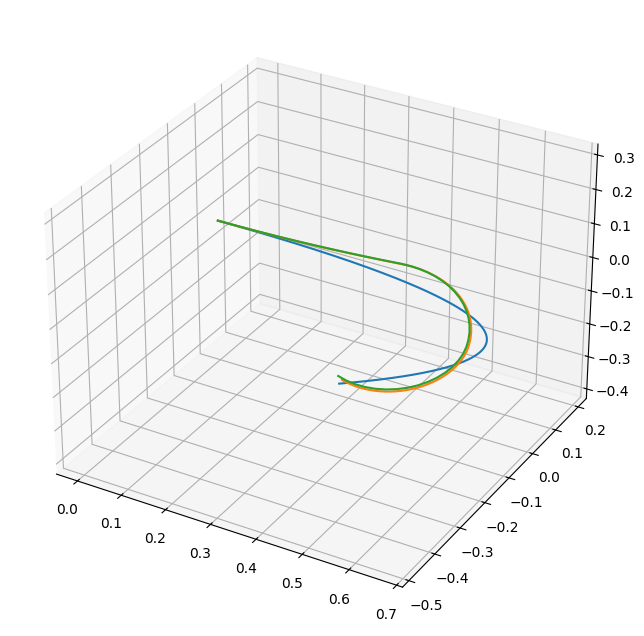

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(target[:,0], target[:,1], target[:,2])
ax.plot(desired[:,0], desired[:,1], desired[:,2])
ax.plot(actual[:,0], actual[:,1], actual[:,2])
set_axes_equal(ax)
plt.show()